# Calling WorkGraph within a WorkChain

## Introduction
Although WorkGraph utilizes Calcfunction, Calcjob, and WorkChain to build workflows, it's not intended to replace the established WorkChain workflow system. As WorkGraph becomes more popular for creating workflows, there may arise scenarios where integrating a WorkGraph workflow within a WorkChain is necessary.

To ensure system consistency, it's essential that WorkChains can seamlessly invoke WorkGraphs.

This tutorial will demonstrate how to integrate a WorkGraph within a WorkChain.

## A Test WorkChain

Let's construct a simple WorkChain that calls a WorkGraph. Consider the following key points:

- **Dynamic Namespace**: Since we we will pass the whole WorkGraph data as input, the WorkChain must define a dynamic namespace to manage WorkGraph inputs.
- **WorkGraph Submission**: Use the `WorkGraphEngine` class to submit a WorkGraph.
- **Customization**: Users can specify a `call_link_label` to customize the link label for the process call.
- **Output Handling**: It's important to understand the output namespace of the WorkGraph to retrieve results correctly.


In [1]:
from aiida.engine import WorkChain


class TestWorkChain(WorkChain):
    @classmethod
    def define(cls, spec):
        super().define(spec)
        spec.input_namespace('workgraph', dynamic=True)
        spec.outline(
            cls.run_workgraph,
            cls.results,
        )
        spec.output('sum')
        spec.output('product')

    def run_workgraph(self):
        from aiida_workgraph.engine.workgraph import WorkGraphEngine
        inputs = {'wg': self.inputs.workgraph,
                 'metadata': {'call_link_label': 'workgraph'}}
        process = self.submit(WorkGraphEngine, **inputs)
        self.to_context(workgraph=process)

    def results(self):
        # make sure that workgraph has outputs: `sum` and `product`
        self.out('sum', self.ctx.workgraph.outputs.sum)
        self.out('product', self.ctx.workgraph.outputs.product)
    

## Prepare the Inputs

In this section, we'll create a basic `add_multiply` WorkGraph and pass it as input to the WorkChain.

Key points to consider:

- **Input Conversion**: Since WorkGraphs cannot be directly converted to AiiDA nodes, it is necessary to export the WorkGraph to a dictionary format before passing it to the WorkChain.
- **Output Exposure**: Configure the WorkGraph to properly expose the outputs. This setup is crucial for the WorkChain to successfully retrieve the outputs. Note that the specific output names and the number of outputs will vary based on the particular use case.


In [4]:
%%capture
from aiida.engine import calcfunction, run_get_node
from aiida import orm, load_profile
from aiida_workgraph import WorkGraph

load_profile()


@calcfunction
def add(x, y):
    return x + y

@calcfunction
def multiply(x, y):
    return x * y

# Create a `add_multiply` WorkGraph
wg = WorkGraph("add_multiply_workflow")
wg.tasks.new(add, name="add", x=orm.Int(1), y=orm.Int(2))
wg.tasks.new(multiply, name="multiply", x = wg.tasks["add"].outputs["result"],
                y=orm.Int(2))
# Define the outputs of the WorkGraph, which are exposed from the `multiply` and `add` tasks
wg.group_outputs = [{"name": "product", "from": "multiply.result"},
                    {"name": "sum", "from": "add.result"}]

# We export the WorkGraph to a dictionary and pass it as input to the WorkChain
inputs={"workgraph": wg.to_dict()}
result, node = run_get_node(TestWorkChain, **inputs)

07/14/2024 05:14:25 AM <2939616> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [91377|WorkGraphEngine|continue_workgraph]: Continue workgraph.
07/14/2024 05:14:25 AM <2939616> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [91377|WorkGraphEngine|continue_workgraph]: tasks ready to run: add
07/14/2024 05:14:25 AM <2939616> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [91377|WorkGraphEngine|run_tasks]: Run task: add, type: CALCFUNCTION
07/14/2024 05:14:25 AM <2939616> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [91377|WorkGraphEngine|run_tasks]: Task: add finished.
07/14/2024 05:14:25 AM <2939616> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [91377|WorkGraphEngine|continue_workgraph]: Continue workgraph.
07/14/2024 05:14:25 AM <2939616> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [91377|WorkGraphEngine|continue_workgraph]: tasks ready to run: multiply
07/14/2

Print out the result and generate the node graph and visualize it.

WorkChain results:
sum:     uuid: 9ab06f2c-1dd3-4009-a70e-6434cf9e5d4f (pk: 91379) value: 3
product: uuid: cc679a49-f17a-4a31-a36f-2da01543cbce (pk: 91381) value: 6


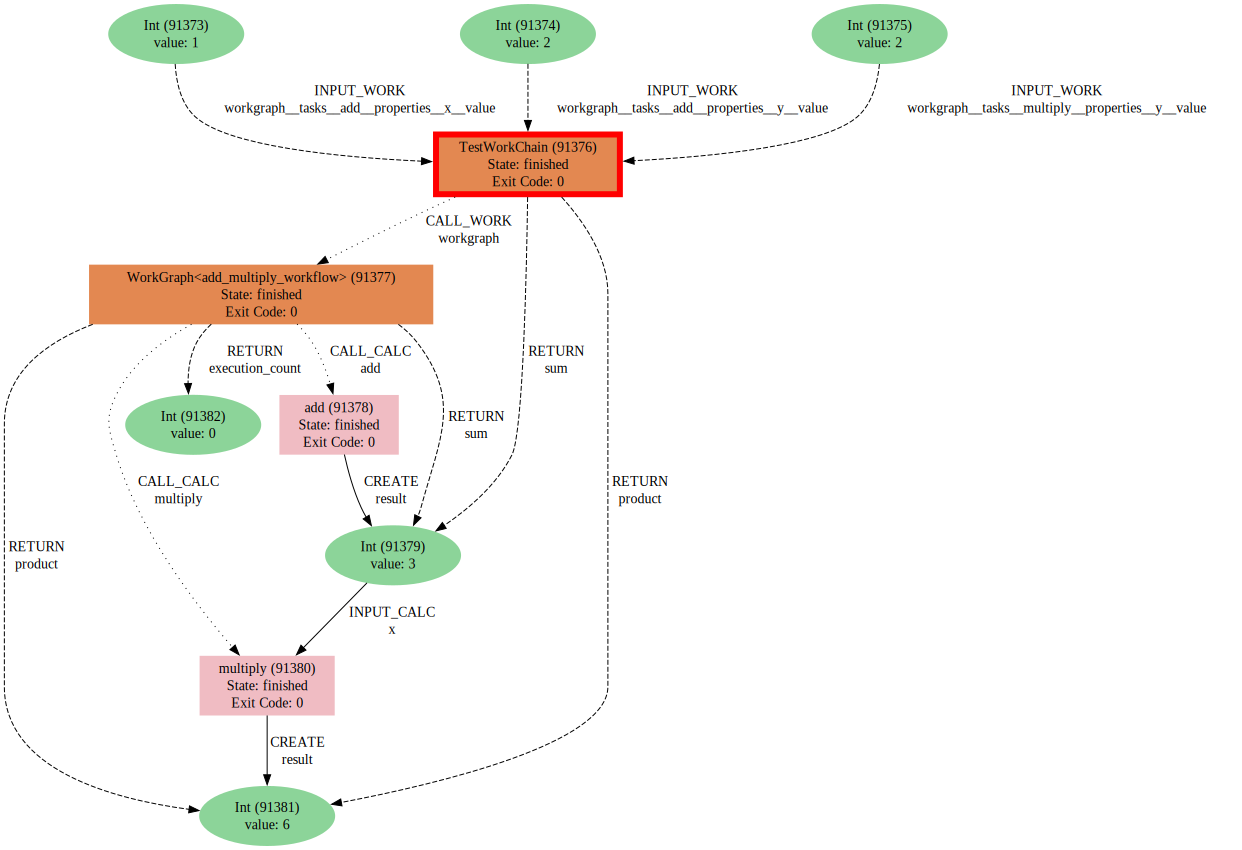

In [10]:
from aiida_workgraph.utils import generate_node_graph
print("WorkChain results:")
print("sum:    ", result['sum'])
print("product:", result['product'])
generate_node_graph(node.pk)

## Summary

In this tutorial, we've covered how to integrate a dynamic WorkGraph within a WorkChain, addressing key aspects such as dynamic input management, process submission, and output retrieval.
